In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ISLP import load_data
from sklearn.model_selection import train_test_split, cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.decomposition import PCA


In [31]:
np.random.seed(0)
college = load_data('College')
#print(college.head())
# The Private predictor is categorical and has to be binary
college['Private'] = college['Private'].map({'Yes':1, 'No' : 0})
x = college.drop(columns= 'Apps')
y = college['Apps']
# a (split data set)
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.3, random_state=42)
#print(np.shape(X_train))
#print(np.shape(X_test))
# (b) Fit a linear model
X_lin = sm.add_constant(X_train)
lin_model = sm.OLS(Y_train, X_lin). fit()
#print(lin_model.summary())

# report the test error
Y_predict = lin_model.predict(sm.add_constant(X_test))
MSE = np.mean((Y_predict - Y_test) ** 2)
print('Obtained test error is:', MSE)

Obtained test error is: 1931803.1942072613


1899348.2332216634


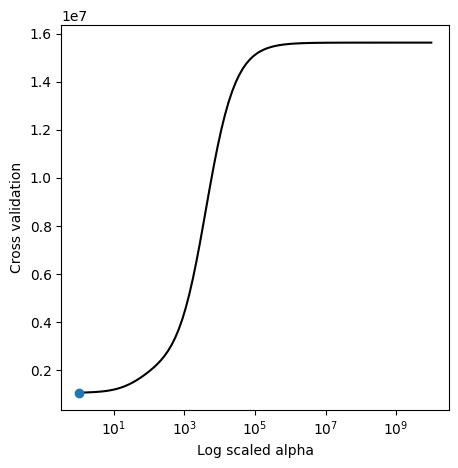

In [71]:
# (c) fit a ridge regression
# ridge requires scaled predictor variables 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# alpha ranges
alpha = np.logspace(0.01, 10, 100)
ridge_cv = RidgeCV(alphas= alpha, store_cv_results=True)
ridge_clf = ridge_cv.fit(X_train_scaled, Y_train)

alpha_min = ridge_clf.alpha_
cv_vals = np.mean(ridge_clf.cv_results_, axis = 0)
cv_min = np.min(cv_vals)

np.shape(cv_vals)

fig, ax = plt.subplots(figsize = (5,5))
ax.plot(alpha, cv_vals, color = 'k')
ax.plot(alpha_min, cv_min, marker = 'o')
ax.set_xscale('log')
#ridge_clf.coef_
ax.set_xlabel('Log scaled alpha')
ax.set_ylabel('Cross validation')

# report the test error
y_predicted = ridge_clf.predict(X_test_scaled)
mse = np.mean((Y_test - y_predicted) ** 2)
print(mse)

Best alpha: 1.023292992280754
1930300.9132145469


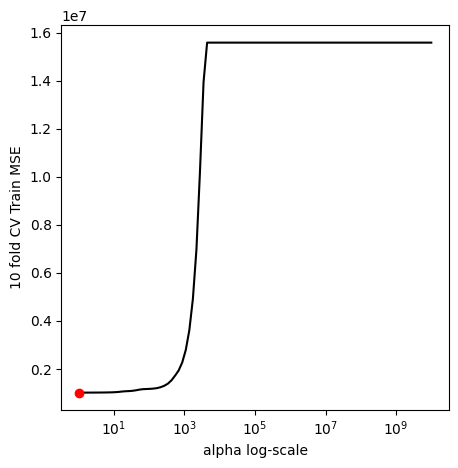

In [88]:
# (d) fit a lasso model 
# keep the alpha (lambda) range as previous :alpha
lasso_cv = LassoCV(alphas = alpha,cv = 10)
lasso_model = lasso_cv.fit(X_train_scaled, Y_train)
alpha_best = lasso_model.alpha_  # Extract best lambda
print("Best alpha:", alpha_best)

# The mse estimates are the mean aross folds (cols)
MSEs = np.mean(lasso_model.mse_path_, axis=1)

# Plot CV error vs alpha
fig, ax = plt.subplots(figsize=(5,5));
ax.plot(lasso_model.alphas_,MSEs, color='k');
ax.plot(alpha_best, np.min(MSEs), marker='o', color='r');
ax.set_xlabel('alpha log-scale');
ax.set_xscale('log')
ax.set_ylabel('10 fold CV Train MSE');

y_predicted = lasso_cv.predict(X_test_scaled)
MSE_test = np.mean((Y_test - y_predicted)**2)
print(MSE_test)

In [92]:
# test, first choose the best alpha and fit the model 
lasso_model_test = Lasso(alpha = alpha_best)
lasso_model_test.fit(X_train_scaled, Y_train)

y_predict = lasso_model_test.predict(X_test_scaled)
MSE_test = np.mean((y_predict - Y_test)**2)
print(MSE_test) 
# both are the same

1930300.9132145469


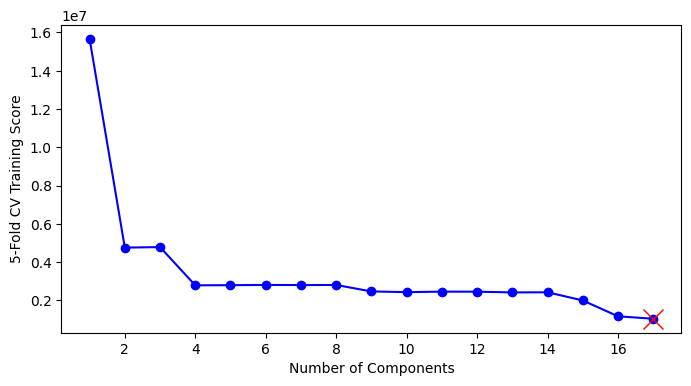

In [141]:
# (e) Fit a PCR model 
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# select the best number of components
num_components = np.arange(1, len(X_train.columns)+1)
MSE_values = [] # store MSE over different Ms
for i in num_components:
    X_train_pca_subset = X_train_pca[:,:i]
    fit_linReg = LinearRegression()
    MSE= -np.mean(cross_val_score(fit_linReg, X_train_pca_subset, Y_train, cv = 5, scoring='neg_mean_squared_error'))
    MSE_values.append(MSE)
MSE_values
#best_component_index, best_component = np.min(MSE_values)# Step 3: Get the best number of components
best_component_index = np.argmin(MSE_values)  
best_component = num_components[best_component_index]  

     
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(num_components,MSE_values, marker='o', color='b');
ax.plot(best_component, MSE_values[best_component_index], marker='x', color='r', markersize = 15);
ax.set_xlabel('Number of Components');
ax.set_ylabel('5-Fold CV Training Score');
#ax.set_xlim;

In [135]:
num_components

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])